In [227]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
torch.cuda.empty_cache()
print(f"Using device: {device}")

Using device: cuda


In [229]:
def simulate_lorenz(initial_state, steps = 500, dt= 0.01, sigma = 10.0, rho = 28.0, beta = 8.0/3.0):
    def lorenz_system(state):
        x, y, z = state
        dxdt = sigma * (y - x)
        dydt = x * (rho - z) - y
        dzdt = x * y - beta * z
        return np.array([dxdt, dydt, dzdt])
    state = np.array(initial_state)
    trajectory = []
    for _ in range(steps):
        trajectory.append(state.copy())
        k1 = lorenz_system(state)
        k2 = lorenz_system(state + 0.5 * dt * k1)
        k3 = lorenz_system(state + 0.5 * dt * k2)
        k4 = lorenz_system(state + dt * k3)
        state += (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return np.array(trajectory)
        

In [231]:
def create_graph_lorenz(trajectory):
    edge_index = []
    for i in range(len(trajectory)-1):
        edge_index.append([i, i+1])
    edge_index = torch.tensor(edge_index, dtype = torch.long).t().contiguous()
    x = torch.tensor(trajectory, dtype = torch.float)

    data = Data(x=x, edge_index = edge_index)
    return data

In [233]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(output_dim)

    def create_full_graph(self, x):
        n = x.size(0)
        edge_index = torch.stack([
            torch.repeat_interleave(torch.arange(n), n),
            torch.tile(torch.arange(n), (n,))
        ]).to(x.device)
        return edge_index
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.float()
        edge_index = self.create_full_graph(x)
        gnn_x = self.conv1(x, edge_index).relu()
        gnn_x = self.norm1(gnn_x)
        gnn_x = self.conv2(gnn_x, edge_index)
        gnn_x = self.norm2(gnn_x)

        fc_x = self.fc1(x).relu()
        fc_x = self.fc3(fc_x).relu()
        fc_x = self.fc3(fc_x)

        return (gnn_x+ fc_x)/2

In [235]:
class KoopmanModel(torch.nn.Module):
    def __init__(self, input_dim, koopman_dim):
        super(KoopmanModel, self).__init__()
        self.encoder = GNN(input_dim, koopman_dim, koopman_dim)
        self.koopman_matrix = torch.nn.Parameter(torch.eye(koopman_dim))
        self.decoder = GNN(koopman_dim, koopman_dim, input_dim)

    def forward(self, data):
        koopman_space = self.encoder(data)
        next_koopman_space = koopman_space @ self.koopman_matrix
        new_data = Data(x=next_koopman_space, edge_index = data.edge_index)
        new_state = self.decoder(new_data)
        return new_state

In [247]:
def auto_encoding_loss(decoded, original_states):
    return F.mse_loss(decoded, original_states)

def prediction_loss(model, koopman_space, data):
    T = data.x.size(0)
    all_predictions = []
    current_state = koopman_space[0].unsqueeze(0)

    for t in range(T):
        decoded_state = model.decoder(Data(x=current_state, edge_index=data.edge_index))
        all_predictions.append(decoded_state)
        if t < T - 1:
            current_state = (current_state @ model.koopman_matrix).detach().clone()
    all_predictions = torch.cat(all_predictions, dim=0)
    return F.mse_loss(all_predictions, data.x)



def metric_loss(koopman_space, original_space):
    distances_koopman = torch.cdist(koopman_space, koopman_space, p=2)
    distances_original = torch.cdist(original_space, original_space, p=2)
    return F.l1_loss(distances_koopman, distances_original)


def total_loss(model, data, lambda1=1.0, lambda2=0.3):
    koopman_space = model.encoder(data)
    decoded = model.decoder(Data(x=koopman_space, edge_index=data.edge_index))
    
    ae_loss = auto_encoding_loss(decoded, data.x)
    pred_loss = prediction_loss(model, koopman_space, data)
    m_loss = metric_loss(koopman_space, data.x)
    #print(f"AE Loss: {ae_loss}, Predicted Loss: Total Loss {m_loss}")

    return ae_loss  + lambda1 * pred_loss + lambda2 * m_loss 

In [239]:
def train_model(model, dataset, epochs = (10),lambda1=1.0, lambda2=0.3, initial_lr = 0.007):
    optimizer = Adam(model.parameters(), lr = initial_lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer,
    #     mode='min',
    #     factor=0.5,
    #     patience=3,
    #     verbose = True
    # )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=5,
        T_mult=2,
        eta_min=1e-5
    )
    model = model.to(device)
    train_losses = []
    learning_rates = []
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for data in dataset:
            data = data.to(device)
            optimizer.zero_grad()
            #prediction = model(data)
            loss = total_loss(model, data,  lambda1=lambda1, lambda2=lambda2)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataset)
        #scheduler.step(avg_loss) For ReduceLRPlateau
        train_losses.append(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        schedular.step()
        if avg_loss < best_loss:
            best_loss = avg_loss
        print(f"Epoch {epoch + 1}, Loss {avg_loss:.4f}, LR: {current_lr:.6f}")

        #For Reduce LR
        # if avg_loss < best_loss:
        #     best_loss = avg_loss
        #     patience_counter = 0
        # else:
        #     patience_counter += 1
        #     if patience_counter >= 10: 
        #         print("Early stopping triggered")
        #         break
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    ax1.plot(range(epochs), train_losses)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training Loss Over Time")
    
    ax2.plot(range(epochs), learning_rates)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Learning Rate")
    ax2.set_title("Learning Rate Schedule")
    plt.tight_layout()
    plt.show()

In [241]:
def normalize_lorenz_trajectory(trajectory):
    scale_factors = np.array([20.0, 30.0, 50.0])
    normalized_trajectory = trajectory / scale_factors
    return normalized_trajectory


initial_state = [1.0, 0.0, 0.0]
lorenz_trajectory = simulate_lorenz(initial_state)
normalized_trajectory = normalize_lorenz_trajectory(lorenz_trajectory)
dataset = [
    create_graph_lorenz(
        normalize_lorenz_trajectory(
            simulate_lorenz([
                np.random.normal(1.0, 0.1), 
                np.random.normal(0.0, 0.1), 
                np.random.normal(0.0, 0.1)
            ])
        )
    ) 
    for _ in range(100)
]

In [242]:
model = KoopmanModel(input_dim = 3, koopman_dim = 3).to(device)

Epoch 1, Loss 0.5957, LR: 0.007000
Epoch 2, Loss 0.1068, LR: 0.007000
Epoch 3, Loss 0.1010, LR: 0.007000
Epoch 4, Loss 0.1015, LR: 0.007000
Epoch 5, Loss 0.1020, LR: 0.007000
Epoch 6, Loss 0.1066, LR: 0.007000
Epoch 7, Loss 0.1060, LR: 0.003500
Epoch 8, Loss 0.1082, LR: 0.003500
Epoch 9, Loss 0.1078, LR: 0.003500
Epoch 10, Loss 0.1078, LR: 0.003500


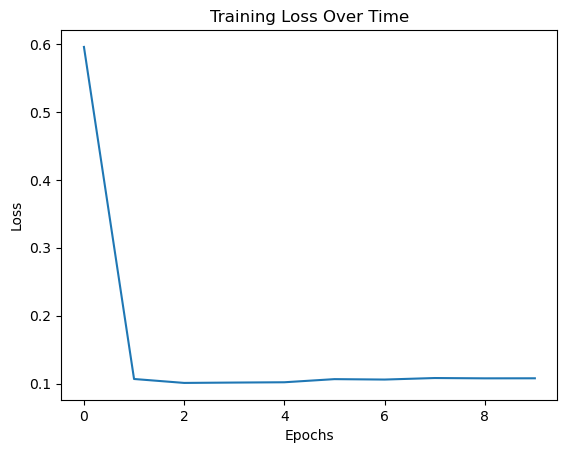

In [245]:
train_model(model, dataset, epochs = 20)